In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler

import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    multilabel_confusion_matrix, 
    roc_curve, 
    auc, 
    precision_recall_curve, 
    accuracy_score, 
    precision_recall_fscore_support, 
    classification_report
)
from tqdm import tqdm
from gensim.models import Word2Vec
import os


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### We are loading the dataset
- Jigsaw toxic comment classification.

In [3]:
df = pd.read_csv('F:\\Text\\Hate_Classifier\\Kaggle Dataset\\train.csv\\train.csv')

- We are verifying if the loaded dataset is right by printing some values 

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- Here in dataset description we can see that there are some duplicate values, So we proceed to removing that.

In [6]:
duplicate_rows = df[df.duplicated(subset=['comment_text'], keep=False)]
print("Duplicate rows based on 'comment_text' column:")
print(duplicate_rows)

# Group by 'comment_text' and check if all label values are identical
df_grouped = df.groupby('comment_text').filter(lambda x: (x.iloc[:, 1:].nunique() == 1).all())
df_grouped.drop_duplicates(subset=['comment_text'], keep='first', inplace=True)
print("Number of rows after merging identical duplicates:", len(df_grouped))
df_grouped.reset_index(drop=True, inplace=True)


Duplicate rows based on 'comment_text' column:
Empty DataFrame
Columns: [id, comment_text, toxic, severe_toxic, obscene, threat, insult, identity_hate]
Index: []
Number of rows after merging identical duplicates: 159571


- Once that is done, we are checking the distribution of the dataset only to notice a drastic difference in the data balance. Such a huge imbalance in data can cause very big issues.


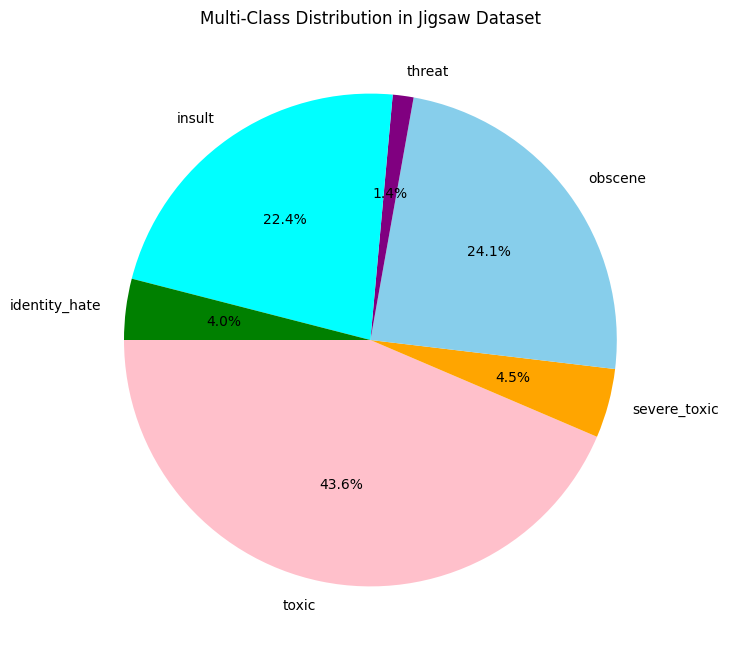

In [7]:
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
class_distribution = df[label_columns].sum()

plt.figure(figsize=(8, 8))
plt.pie(class_distribution, labels=label_columns, autopct='%1.1f%%', startangle=180, colors=['pink', 'orange', 'skyblue', 'purple', 'cyan', 'green'])
plt.title('Multi-Class Distribution in Jigsaw Dataset')
plt.show()


- Expanding shortforms and cleaning the text without using any inbuilt functions. Uploaded the dataset to ChatGPT and asked it to give the words commonly used in shortform and using regex it was expanded.

In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [9]:
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))

In [10]:
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
total_samples = len(df)
class_counts = np.array([df[label].sum() for label in label_columns])
class_weights = total_samples / (len(label_columns) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [17]:
import os
if os.path.exists("word2vec.model") and os.path.exists("embedding_matrix.npy"):
    print("Loading pre-trained Word2Vec model...")
    w2v_model = Word2Vec.load("word2vec.model")
    embedding_matrix = np.load("embedding_matrix.npy")
else:
    sentences = [comment.split() for comment in df["comment_text"]]
    w2v_model = Word2Vec(sentences, vector_size=300, window=5, min_count=2, workers=4)
    w2v_model.save("word2vec.model")

    def get_embedding_matrix(word2vec_model, vocab):
        embedding_matrix = np.zeros((len(vocab) + 1, 300))
        word_to_idx = {word: idx for idx, word in enumerate(vocab, 1)}
        for word, idx in word_to_idx.items():
            if word in word2vec_model.wv:
                embedding_matrix[idx] = word2vec_model.wv[word]
        return embedding_matrix, word_to_idx

    vocab = set(word for sentence in sentences for word in sentence)
    embedding_matrix, word_to_idx = get_embedding_matrix(w2v_model, vocab)
    np.save("embedding_matrix.npy", embedding_matrix)

# ---- TEXT VECTORIZATION ----
def vectorize_text(sentences, word_to_idx, max_len=25):
    vectorized = np.zeros((len(sentences), max_len, 300), dtype=np.float32)
    for i, sentence in enumerate(sentences):
        for j, word in enumerate(sentence[:max_len]):
            if word in word_to_idx:
                vectorized[i, j] = embedding_matrix[word_to_idx[word]]
    return vectorized

X = vectorize_text(sentences, word_to_idx)
Y = df[label_columns].values

## Model Building and training

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [19]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

In [20]:
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
class BiLSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        attn_out = torch.sum(lstm_out * attn_weights, dim=1)
        return self.fc(self.dropout(attn_out))

In [22]:
input_dim = 300  # Word2Vec embedding size
hidden_dim = 128
output_dim = 6

In [23]:
bilstm_model = BiLSTMAttention(input_dim, hidden_dim, output_dim).to(device)

In [24]:
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
optimizer = optim.Adam(bilstm_model.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_dataloader, epochs=5):
    model.train()
    scaler = torch.amp.GradScaler(device=device)  

    for epoch in range(epochs):
        total_loss = 0
        loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")

        for X_batch, Y_batch in loop:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast(device_type="cuda"): 
                outputs = model(X_batch)
                loss = criterion(outputs, Y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_dataloader):.4f}")

    torch.save(model.state_dict(), "bilstm_toxicity.pth")
    print("Model saved successfully.")

train_model(bilstm_model, train_dataloader)


Epoch 1: 100%|██████████| 3990/3990 [01:19<00:00, 50.00it/s, loss=0.169]  


Epoch 1, Loss: 0.1624


Epoch 2: 100%|██████████| 3990/3990 [01:04<00:00, 62.14it/s, loss=0.0141] 


Epoch 2, Loss: 0.1420


Epoch 3: 100%|██████████| 3990/3990 [01:05<00:00, 60.79it/s, loss=0.0153] 


Epoch 3, Loss: 0.1285


Epoch 4: 100%|██████████| 3990/3990 [01:04<00:00, 61.48it/s, loss=0.121]  


Epoch 4, Loss: 0.1167


Epoch 5: 100%|██████████| 3990/3990 [01:09<00:00, 57.36it/s, loss=0.419]   


Epoch 5, Loss: 0.1062
Model saved successfully.


In [29]:
# ---- LOAD MODEL ----
bilstm_model.load_state_dict(torch.load("bilstm_toxicity.pth", map_location=device))
bilstm_model.to(device)

# ---- CONTINUE TRAINING ----
def train_model_resume(model, train_dataloader, optimizer, start_epoch=6, epochs=10):
    model.train()
    scaler = torch.amp.GradScaler(device=device)  

    for epoch in range(start_epoch, epochs + 1):
        total_loss = 0
        loop = tqdm(train_dataloader, desc=f"Epoch {epoch}")

        for X_batch, Y_batch in loop:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast(device_type="cuda"): 
                outputs = model(X_batch)
                loss = criterion(outputs, Y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch}, Loss: {total_loss / len(train_dataloader):.4f}")

    torch.save(model.state_dict(), "bilstm_toxicity.pth")
    print("Model saved successfully.")

# ---- RESUME TRAINING ----
train_model_resume(bilstm_model, train_dataloader, optimizer, start_epoch=6, epochs=10)


Epoch 6: 100%|██████████| 3990/3990 [01:13<00:00, 53.94it/s, loss=0.00848]


Epoch 6, Loss: 0.0978


Epoch 7: 100%|██████████| 3990/3990 [01:02<00:00, 63.51it/s, loss=0.0473]  


Epoch 7, Loss: 0.0891


Epoch 8: 100%|██████████| 3990/3990 [00:37<00:00, 105.18it/s, loss=0.0535] 


Epoch 8, Loss: 0.0831


Epoch 9: 100%|██████████| 3990/3990 [00:38<00:00, 103.17it/s, loss=0.0477] 


Epoch 9, Loss: 0.0783


Epoch 10: 100%|██████████| 3990/3990 [00:38<00:00, 103.33it/s, loss=0.0558] 


Epoch 10, Loss: 0.0733
Model saved successfully.


In [ ]:
# ---- LOAD MODEL ----
bilstm_model.load_state_dict(torch.load("bilstm_toxicity.pth", map_location=device))
bilstm_model.to(device)

# ---- CONTINUE TRAINING ----
def train_model_resume(model, train_dataloader, optimizer, start_epoch=6, epochs=10):
    model.train()
    scaler = torch.amp.GradScaler(device=device)  

    for epoch in range(start_epoch, epochs + 1):
        total_loss = 0
        loop = tqdm(train_dataloader, desc=f"Epoch {epoch}")

        for X_batch, Y_batch in loop:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast(device_type="cuda"): 
                outputs = model(X_batch)
                loss = criterion(outputs, Y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch}, Loss: {total_loss / len(train_dataloader):.4f}")

    torch.save(model.state_dict(), "bilstm_toxicity.pth")
    print("Model saved successfully.")

# ---- RESUME TRAINING ----
train_model_resume(bilstm_model, train_dataloader, optimizer, start_epoch=10, epochs=20)


Epoch 10: 100%|██████████| 3990/3990 [00:40<00:00, 99.66it/s, loss=0.00234] 


Epoch 10, Loss: 0.0692


Epoch 11: 100%|██████████| 3990/3990 [00:40<00:00, 97.97it/s, loss=0.0393]  


Epoch 11, Loss: 0.0654


Epoch 12: 100%|██████████| 3990/3990 [00:38<00:00, 103.81it/s, loss=0.065]  


Epoch 12, Loss: 0.0621


Epoch 13: 100%|██████████| 3990/3990 [00:38<00:00, 102.41it/s, loss=0.0485] 


Epoch 13, Loss: 0.0618


Epoch 14: 100%|██████████| 3990/3990 [00:38<00:00, 102.81it/s, loss=0.797]   


Epoch 14, Loss: 0.0566


Epoch 15: 100%|██████████| 3990/3990 [00:38<00:00, 102.67it/s, loss=0.0302] 


Epoch 15, Loss: 0.0554


Epoch 16: 100%|██████████| 3990/3990 [00:39<00:00, 102.18it/s, loss=0.34]    


Epoch 16, Loss: 0.0540


Epoch 17: 100%|██████████| 3990/3990 [00:40<00:00, 98.06it/s, loss=0.114]    


Epoch 17, Loss: 0.0520


Epoch 18: 100%|██████████| 3990/3990 [00:39<00:00, 100.29it/s, loss=0.0319]  


Epoch 18, Loss: 0.0493


Epoch 19: 100%|██████████| 3990/3990 [00:38<00:00, 103.40it/s, loss=0.00183]


Epoch 19, Loss: 0.0485


Epoch 20: 100%|██████████| 3990/3990 [00:39<00:00, 101.70it/s, loss=0.00415] 

Epoch 20, Loss: 0.0462
Model saved successfully.


In [33]:
# ---- LOAD MODEL ----
bilstm_model.load_state_dict(torch.load("bilstm_toxicity.pth", map_location=device))
bilstm_model.to(device)

# ---- CONTINUE TRAINING ----
def train_model_resume(model, train_dataloader, optimizer, start_epoch=6, epochs=10):
    model.train()
    scaler = torch.amp.GradScaler(device=device)  

    for epoch in range(start_epoch, epochs + 1):
        total_loss = 0
        loop = tqdm(train_dataloader, desc=f"Epoch {epoch}")

        for X_batch, Y_batch in loop:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()

            with torch.amp.autocast(device_type="cuda"): 
                outputs = model(X_batch)
                loss = criterion(outputs, Y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        print(f"Epoch {epoch}, Loss: {total_loss / len(train_dataloader):.4f}")

    torch.save(model.state_dict(), "bilstm_toxicity.pth")
    print("Model saved successfully.")

# ---- RESUME TRAINING ----
train_model_resume(bilstm_model, train_dataloader, optimizer, start_epoch=21, epochs=30)


Epoch 21: 100%|██████████| 3990/3990 [00:40<00:00, 99.51it/s, loss=0.346]    


Epoch 21, Loss: 0.0459


Epoch 22: 100%|██████████| 3990/3990 [00:40<00:00, 98.28it/s, loss=0.00166]  


Epoch 22, Loss: 0.0442


Epoch 23: 100%|██████████| 3990/3990 [00:38<00:00, 104.05it/s, loss=0.11]    


Epoch 23, Loss: 0.0435


Epoch 24: 100%|██████████| 3990/3990 [00:41<00:00, 96.77it/s, loss=0.0024]   


Epoch 24, Loss: 0.0438


Epoch 25: 100%|██████████| 3990/3990 [00:39<00:00, 101.52it/s, loss=0.0106]  


Epoch 25, Loss: 0.0425


Epoch 26: 100%|██████████| 3990/3990 [00:38<00:00, 103.00it/s, loss=0.000529]


Epoch 26, Loss: 0.0408


Epoch 27: 100%|██████████| 3990/3990 [00:38<00:00, 103.12it/s, loss=0.00979] 


Epoch 27, Loss: 0.0413


Epoch 28: 100%|██████████| 3990/3990 [00:39<00:00, 101.94it/s, loss=0.0342]  


Epoch 28, Loss: 0.0399


Epoch 29: 100%|██████████| 3990/3990 [00:39<00:00, 102.16it/s, loss=0.241]   


Epoch 29, Loss: 0.0390


Epoch 30: 100%|██████████| 3990/3990 [00:40<00:00, 98.74it/s, loss=0.0161]   

Epoch 30, Loss: 0.0385
Model saved successfully.


In [34]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, Y_batch in dataloader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            outputs = model(X_batch)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()

            all_preds.append(preds.cpu().numpy())
            all_labels.append(Y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="samples", zero_division=1)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

# ---- LOAD MODEL & EVALUATE ----
bilstm_model.load_state_dict(torch.load("bilstm_toxicity.pth", map_location=device))
evaluate_model(bilstm_model, test_dataloader)

Accuracy: 0.9033
Precision: 0.9643
Recall: 0.9637
F1-score: 0.9358
